# Transfer-learning MNIST with Pytorch
Currently Pytorch seems to be hip and cool: from many people I hear that they are using it and like to use it. To see how Pytorch handles I decided to try some experiments with MNIST: building an autoencoder and transfer learning. 

Let's start with the imports that I used: 


In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import numpy as np


use_cuda = torch.cuda.is_available()
NUM_EPOCHS_ENCODER = 3



## Loading data
An interesting aspect of Pytorch are the data loaders. For my transfer learning I decided that I wanted to load three sets of images: 
- A train set for the autoencoder 
- A train set for the classifier
- A test set

What I liked is that I could easily load these datasets, and split one of them using the random_split function...

In [2]:
root = './data'
download = True  # download MNIST dataset or not

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=download)
test_set = datasets.MNIST(root=root, train=False, transform=trans)

split_fraction = 0.8
train_length = int(len(train_set)*split_fraction)
partitions = [train_length, len(train_set)-train_length]
autoencoder_trainset,classifier_trainset = random_split(train_set, partitions)


train_batch_size = 100
test_batch_size = 1000
autoencoder_train_loader = torch.utils.data.DataLoader(
                 dataset=autoencoder_trainset,
                 batch_size=train_batch_size,
                 shuffle=True)

classifier_train_loader = torch.utils.data.DataLoader(
                 dataset=classifier_trainset,
                 batch_size=train_batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=test_batch_size,
                shuffle=False)


## Defining a network
Not it's time to define our neural network. It feels kind of weird to create a class with a forward function in Pytorch, but it does give you a lot of flexibility on the forward pass. An example I found online had a different amount of layers depending on some variables on the forward pass. Although I can't immediately see how this is useful it's interesting that it's possible...

In [3]:
class Encoder(nn.Module):
    def __init__(self, last_layer):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28,300)
        self.fc2 = nn.Linear(300,last_layer)
      
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, input_n):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_n, 300)
        self.fc2 = nn.Linear(300,28*28)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 28, 28)
        return x
    
    

## Defining your network
This is something that feels quite good. Once you have your classes defined you easily build your network with these lego blocks. Tensorflow is also supposed to feel like lego blocks, but I always feel a bit weird and handicapped if I have to attach weird inputs to weird outputs. 


In [4]:
latent_dimension = 2
encoder = Encoder(latent_dimension)
decoder = Decoder(latent_dimension)
model = nn.Sequential(encoder, decoder)

if use_cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()


## Training
This is something in Pytorch that I don't really like. In TensorFlow you define the optimizer in the graph and only have to call one function. Here it's difficult to see what's happening and what is optimizing what. If you think this is the best thing ever: please send me a message and let me know why. 


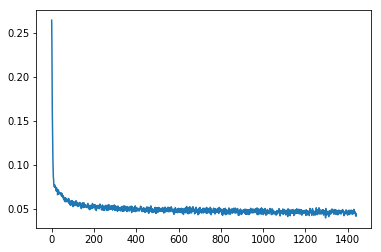

In [5]:
def train_autoencoder(model, loss_criterion, loss_optimizer):
    model.train()
    loss_hist = list()
    for _ in range(NUM_EPOCHS_ENCODER):
        for batch_idx, (x, target) in enumerate(autoencoder_train_loader):
            if use_cuda:
                x = x.cuda()
            x = Variable(x)
            output = model(x)
            loss = loss_criterion(output, x)
            loss_hist.append(loss.data[0])
            loss_optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_hist
loss_hist = train_autoencoder(model, criterion, optimizer)
plt.plot(loss_hist)

## Visualising our latent space
Now that we programmed an autoencoder with a latent dimension of two we can visualise the results of the encoder in two dimensions. This is something I liked about pytorch: I simply took the variable for the encoder and can pass it around... 

What I do not really like however is that I already had a loader, but it took me 5 lines to get the input images for the encoder...

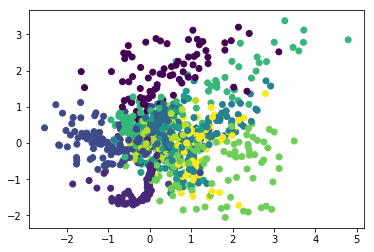

In [6]:
test_data = iter(test_loader)
test_images, test_labels = next(test_data)
test_images = Variable(test_images)
if use_cuda:
    test_images = test_images.cuda()
encoded = encoder(test_images)

encoded_data = encoded.data.cpu().numpy()
plt.scatter(x=encoded_data[:,0], y=encoded_data[:,1],c=test_labels)

### Retraining with a larger latent space
Two is really small for a latent space. We increase it to 10 and repeat training so we get a better autoencoder

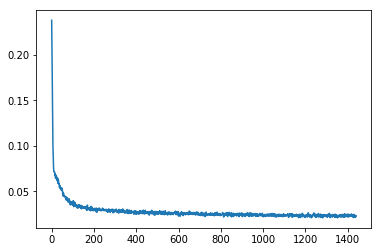

In [7]:
latent_dimension = 10
encoder = Encoder(latent_dimension)
decoder = Decoder(latent_dimension)
model = nn.Sequential(encoder, decoder)


if use_cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

loss_hist = train_autoencoder(model, criterion, optimizer)
plt.plot(loss_hist)

### Use the output of the encoder as input for the classifier


In [8]:
class FinalPrediction(nn.Module):
    def __init__(self, latent_in):
        super(FinalPrediction, self).__init__()
        self.fc1 = nn.Linear(latent_in,300)
        self.fc2 = nn.Linear(300,100)
        self.fc3 = nn.Linear(100,10)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### Use this pretrained model and check the results

In [13]:

model = nn.Sequential(encoder, FinalPrediction(latent_dimension))
if use_cuda:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

def train_classifier(model, data):
    model.train()
    for batch_idx, (data, target) in enumerate(classifier_train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        output = F.log_softmax(output, dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
train_classifier(model, classifier_train_loader)    

In [14]:
def evaluate_model(model, data):
    model.eval()
    loader = iter(data)
    image, label = next(loader)
    data, target = Variable(image), Variable(label)
    data = data.cuda()
    prediction = model(data)

    index = np.argmax(prediction.data.cpu().numpy(), axis=1)
    print(sum(index==label)/len(index))
evaluate_model(model, test_loader)

0.879


### Verify that we transfer learned
Let's compare the output of our transfer learned model to a model with a normal initialised encoder...

In [12]:
encoder = Encoder(latent_dimension)
model = nn.Sequential(encoder, FinalPrediction(latent_dimension))
if use_cuda:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()


train_classifier(model, classifier_train_loader)

    
evaluate_model(model, test_loader)

0.863


## Conclusion
Great results! Looks like it is indeed better for MNIST to train an autoencoder first, and then use the latent space as input for a classifier. 

As this was just a test to see what Pytorch can do and can't do I did not dive into any optimizations or any nicer code. Please explore a bit for yourself!
